CandNo. 277191

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, PowerTransformer
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MaxAbsScaler
from keras.layers import BatchNormalization, LeakyReLU
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from sklearn.preprocessing import PowerTransformer, MaxAbsScaler

Import other datasets

In [3]:
crop_production = pd.read_csv('Crops production indicators - FAOSTAT_data_en_2-22-2024.csv')
emissions = pd.read_csv('Emissions - FAOSTAT_data_en_2-27-2024.csv')

employment = pd.read_csv('Employment - FAOSTAT_data_en_2-27-2024.csv')
exchange_rate = pd.read_csv('Exchange rate - FAOSTAT_data_en_2-22-2024.csv')
fertilizers_use = pd.read_csv('Fertilizers use - FAOSTAT_data_en_2-27-2024.csv')

food_balances_indicators = pd.read_csv('Food balances indicators - FAOSTAT_data_en_2-22-2024.csv')
foreign_direct = pd.read_csv('Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv')

land_temperature_change = pd.read_csv('Land temperature change - FAOSTAT_data_en_2-27-2024.csv')
land_use = pd.read_csv('Land use - FAOSTAT_data_en_2-22-2024.csv')
pesticides_use = pd.read_csv('Pesticides use - FAOSTAT_data_en_2-27-2024.csv')
consumer_prices = pd.read_csv('Consumer prices indicators - FAOSTAT_data_en_2-22-2024.csv')


C:\Users\user\AppData\Local\Temp\ipykernel_14968\3078081136.py:12: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  land_use = pd.read_csv('Land use - FAOSTAT_data_en_2-22-2024.csv')


df_food_trade

In [4]:
df_food_trade = pd.read_csv('Food trade indicators - FAOSTAT_data_en_2-22-2024.csv')
df_food_trade.drop(['Note','Flag Description','Flag'],inplace=True,axis=1)
df_food_trade['Item_Element'] = df_food_trade['Item'] + " " + df_food_trade['Element']
df_food_trade = df_food_trade.groupby(['Area','Year','Item_Element'])['Value'].sum().sort_values(ascending=False).reset_index()
df_food_trade = df_food_trade.pivot_table(index=["Area","Year"], columns='Item_Element', values='Value', aggfunc='sum').reset_index()
df_food_trade['total_y'] = df_food_trade[[col for col in df_food_trade.columns if 'Export Value' in col]].sum(axis=1)

df_food_trade

Item_Element,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Non-edible Fats and Oils Import Value,Non-food Export Value,Non-food Import Value,Other food Export Value,Other food Import Value,Sugar and Honey Export Value,Sugar and Honey Import Value,Tobacco Export Value,Tobacco Import Value,total_y
0,Afghanistan,1991,NaN,0.00,NaN,41600.00,NaN,4590.00,NaN,28300.00,...,0.00,45055.00,12000.00,1330.00,26360.00,0.00,4900.00,0.00,12000.00,98243.00
1,Afghanistan,1992,NaN,0.00,NaN,25600.00,NaN,3550.00,NaN,34800.00,...,0.00,22300.00,15200.00,750.00,18300.00,0.00,17800.00,0.00,15200.00,42112.00
2,Afghanistan,1993,NaN,0.00,NaN,40000.00,NaN,4020.00,NaN,12000.00,...,0.00,22300.00,17800.00,940.00,28040.00,0.00,14100.00,0.00,17800.00,44564.00
3,Afghanistan,1994,NaN,0.00,NaN,25700.00,NaN,3700.00,NaN,5300.00,...,0.00,22800.00,21000.00,650.00,21680.00,0.00,16800.00,0.00,21000.00,50357.00
4,Afghanistan,1995,NaN,0.00,NaN,37720.00,NaN,1500.00,NaN,61400.00,...,0.00,24800.00,24600.00,556.00,45315.00,0.00,19200.00,0.00,24600.00,49596.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,Zimbabwe,2018,526.02,10965.38,7562.86,293431.28,194.65,17895.61,1415.42,150245.70,...,6917.67,1009162.92,108272.85,31403.90,75876.99,44521.70,9146.66,893113.05,24977.84,2036609.89
6201,Zimbabwe,2019,201.57,754.42,9134.56,153705.24,3456.33,11937.38,414.37,92059.69,...,858.78,908394.82,56019.51,29066.73,50205.38,62833.58,2344.18,828488.44,7215.50,1896675.90
6202,Zimbabwe,2020,116.31,2728.55,17120.49,601835.56,3637.97,12512.43,1031.10,169234.15,...,7217.60,861397.05,84280.25,24920.78,66854.07,76932.73,4667.07,794956.99,18370.85,1827765.88
6203,Zimbabwe,2021,210.92,10390.20,16227.95,407807.82,3271.41,44239.63,1020.70,279897.98,...,12044.20,958413.59,103964.94,23089.87,131186.29,17141.21,22194.92,836533.69,18265.04,1907255.61


crop_production
1. I drop unless columns
2. I grouped by ['Area','Year','Item'] with the sum value 
3. I created a pivot_table to expand all the Item categories for model training later
4. I created a total_crop_production for model training

In [5]:
crop_production.drop(['Note','Flag Description','Flag','Year Code','Item Code (CPC)','Area Code (M49)','Domain Code','Domain','Element','Element Code','Unit'],inplace=True,axis=1)
crop_production = crop_production.groupby(['Area','Year','Item'])['Value'].sum().sort_values(ascending=False).reset_index()
crop_production = crop_production.pivot_table(index=["Area","Year"], columns='Item', values='Value', aggfunc='sum').reset_index()
crop_production['total_crop_production'] = crop_production.iloc[:, 2:].sum(axis=1)
merged_crop_production = pd.merge(df_food_trade,crop_production,
                                      left_on=['Year', 'Area'], 
                                      right_on=['Year', 'Area'], 
                                      how='left')
merged_crop_production.fillna(0, inplace=True)
merged_crop_production.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,"Fibre Crops, Fibre Equivalent",Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses, Total","Roots and Tubers, Total",Sugar Crops Primary,"Treenuts, Total",Vegetables Primary,total_crop_production
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now do the emissions
1. I concatenated both Item and Element to get the unqiue category
2. I drop unless columns
3. I grouped by ['Area','Year','Item_Element'] with the sum value 
4. I created a pivot_table to expand all the Item_Element categories for model training later
5. I created a total_emissions for model training

In [6]:
emissions.duplicated(subset=['Area','Year']).sum()

23780

In [7]:
emissions['Item_Element'] = emissions['Item'] + " " + emissions['Element']
emissions.drop(['Element','Item','Note','Flag Description','Flag','Year Code','Item Code (CPC)','Area Code (M49)','Domain Code','Domain','Element Code','Unit','Source','Source Code'],inplace=True,axis=1)
emissions = emissions.groupby(['Area','Year','Item_Element'])['Value'].sum().sort_values(ascending=False).reset_index()
emissions = emissions.pivot_table(index=["Area","Year"], columns='Item_Element', values='Value', aggfunc='sum').reset_index()
emissions['total_emissions'] = emissions.iloc[:, 2:].sum(axis=1)
merged_emissions = pd.merge(merged_crop_production, emissions, 
                             left_on=['Year', 'Area'], 
                             right_on=['Year', 'Area'], 
                             how='left')
merged_emissions.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,"Treenuts, Total",Vegetables Primary,total_crop_production,All Crops Crops total (Emissions CH4),All Crops Crops total (Emissions N2O),Cropland organic soils Emissions (CO2),Cropland organic soils Emissions (N2O),Grassland organic soils Emissions (CO2),Grassland organic soils Emissions (N2O),total_emissions
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now do the employment
1. I used whereever Unit is 1000 divided by 1000 
2. I concatenated both Indicator and Source to get the unqiue category
3. I drop unless columns
4. I grouped by ['Area','Year'] with the mean value of Adjusted Value
5. I created a pivot_table to expand all the Indicator_Source categories for model training later
6. I did not add the total because it doesn't make sense to add the employment rate 


In [8]:
employment['Adjusted Value'] = employment.apply(lambda x: x['Value'] / 1000 if x['Unit'] == '1000 No' else x['Value'], axis=1)
employment['Indicator_Source'] = employment['Indicator'] + " " + employment['Source']
employment.drop(['Value','Source Code','Source','Indicator','Indicator Code','Sex Code','Sex','Element','Note','Flag Description','Flag','Year Code','Area Code (M49)','Domain Code','Domain','Element Code','Unit','Source','Source Code'],inplace=True,axis=1)
employment = employment.groupby(['Area','Year','Indicator_Source'])['Adjusted Value'].mean().sort_values(ascending=False).reset_index()
employment = employment.pivot_table(index=["Area","Year"], columns='Indicator_Source', values='Adjusted Value', aggfunc='mean').reset_index()
merged_employment = pd.merge(merged_emissions, employment, 
                                            on=['Year', 'Area'], 
                                            how='left')
merged_employment.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Grassland organic soils Emissions (CO2),Grassland organic soils Emissions (N2O),total_emissions,"Employment in agriculture, forestry and fishing - ILO modelled estimates ILO - ILO Modelled Estimates","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Employment surveys","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Household income and expenditure survey","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Household survey","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Labour force survey","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Official estimates","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Population census"
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
merged_employment.duplicated(subset=['Area','Year']).sum()

0

Now do the Exchange rates  ==c
1. I drop unless columns
2. I grouped by ['Area','Year'] with the mean Value
3. I did not add the total because it doesn't make sense to add the employment rate 


In [10]:
exchange_rate.drop(['Months Code','Months','Element','Element Code','Currency','ISO Currency Code (FAO)','Flag Description','Flag','Year Code','Area Code (M49)','Domain Code','Domain','Element Code','Unit'],inplace=True,axis=1)
exchange_rate = exchange_rate.groupby(['Area','Year'])['Value'].mean().sort_values(ascending=False).reset_index()
merged_exchange_rate = pd.merge(merged_employment, exchange_rate, 
                                            on=['Year', 'Area'], 
                                            how='left')
merged_exchange_rate.rename(columns={'Value': 'exchange_rate'}, inplace=True)
merged_exchange_rate.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Grassland organic soils Emissions (N2O),total_emissions,"Employment in agriculture, forestry and fishing - ILO modelled estimates ILO - ILO Modelled Estimates","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Employment surveys","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Household income and expenditure survey","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Household survey","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Labour force survey","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Official estimates","Mean weekly hours actually worked per employed person in agriculture, forestry and fishing Population census",exchange_rate
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.599605
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.599605
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.599605
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,425.099934
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,833.333333


In [11]:
merged_exchange_rate.duplicated(subset=['Area','Year']).sum()

0

Now do the fertilizers_use
1. I drop unless columns
2. I grouped by ['Area','Year','Item] with the sum Value, it meakes snese to sum the tons of fertilizers use
3. I add the total because it make sense to add the all the fertilizers use, which also helps the model to pick up more complicated patterns

In [12]:
fertilizers_use.drop(['Domain Code','Domain','Area Code (M49)','Element Code','Element','Item Code','Flag Description','Year Code','Unit','Area Code (M49)','Flag','Flag Description'],inplace=True,axis=1)
fertilizers_use = fertilizers_use.groupby(['Area','Year','Item'])['Value'].sum().sort_values(ascending=False).reset_index()
fertilizers_use = fertilizers_use.pivot_table(index=["Area","Year"], columns='Item', values='Value', aggfunc='sum').reset_index()
fertilizers_use['total_fertilizers'] = fertilizers_use.iloc[:, 2:].sum(axis=1)
merged_fertilizers_use = pd.merge(merged_exchange_rate, fertilizers_use, 
                                            on=['Year', 'Area'], 
                                            how='left')
merged_fertilizers_use.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Phosphate rock,Potassium chloride (muriate of potash) (MOP),Potassium nitrate,Potassium sulphate (sulphate of potash) (SOP),Sodium nitrate,Superphosphates above 35%,"Superphosphates, other",Urea,Urea and ammonium nitrate solutions (UAN),total_fertilizers
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
merged_fertilizers_use.duplicated(subset=['Area','Year']).sum()

0

Now do the food_balances_indicators
1. I first concatenated both element and item to make sure all the unique categories are obtained 
2. I drop unless columns, since they dont contribute to training the model.
3. I grouped by ['Area','Year','food_balances_Item_Element] with the sum Value, it meakes snese to sum the tons of food_balances_indicators use
4. I add the total because it make sense to add the all the food_balances_indicators, which also helps the model to pick up more complicated patterns

In [14]:
food_balances_indicators['food_balances_Item_Element'] = food_balances_indicators['Element'] + " " + food_balances_indicators['Item']
food_balances_indicators.drop(['Domain Code','Domain','Area Code (M49)','Element Code','Element','Item','Year Code','Unit','Flag','Flag Description'],inplace=True,axis=1)
food_balances_indicators = food_balances_indicators.groupby(['Area','Year','food_balances_Item_Element'])['Value'].sum().sort_values(ascending=False).reset_index()
food_balances_indicators = food_balances_indicators.pivot_table(index=["Area","Year"], columns='food_balances_Item_Element', values='Value', aggfunc='sum').reset_index()
food_balances_indicators['food_balance_sum'] = food_balances_indicators.iloc[:, 2:].sum(axis=1)
merged_food_balances_indicators = pd.merge(merged_fertilizers_use, food_balances_indicators, 
                                            on=['Year', 'Area'], 
                                            how='left')

merged_food_balances_indicators.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Other uses (non-food) Pulses,Other uses (non-food) Spices,Other uses (non-food) Starchy Roots,Other uses (non-food) Stimulants,Other uses (non-food) Sugar & Sweeteners,Other uses (non-food) Sugar Crops,Other uses (non-food) Treenuts,Other uses (non-food) Vegetable Oils,Other uses (non-food) Vegetables,
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
merged_food_balances_indicators.duplicated(subset=['Area','Year']).sum()

0

Since food_security_indicators is not clear on its year column, we will skip it for now.

Now do the foreign_direct_val
1. I drop unless columns, since they dont contribute to training the model.
2. I grouped by ['Area','Year','Item] with the sum Value, it meakes snese to sum the tons of food_balances_indicators use
3. I add the total because it make sense to add the all the food_balances_indicators, which also helps the model to pick up more complicated patterns

In [16]:
foreign_direct.drop(['Domain Code','Domain','Area Code (M49)','Element Code','Element','Item Code','Year Code','Unit','Flag','Flag Description','Note'],inplace=True,axis=1)
foreign_direct = foreign_direct.groupby(['Area','Year','Item'])['Value'].sum().sort_values(ascending=False).reset_index()
foreign_direct = foreign_direct.pivot_table(index=["Area","Year"], columns='Item', values='Value', aggfunc='sum').reset_index()
foreign_direct['total_foreign_direct'] = foreign_direct.iloc[:, 2:].sum(axis=1)
merged_foreign_direct = pd.merge(merged_food_balances_indicators, foreign_direct, 
                                            on=['Year', 'Area'], 
                                            how='left')

merged_foreign_direct.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Other uses (non-food) Vegetable Oils,Other uses (non-food) Vegetables,,"FDI inflows to Agriculture, Forestry and Fishing","FDI inflows to Food, Beverages and Tobacco","FDI outflows to Agriculture, Forestry and Fishing","FDI outflows to Food, Beverages and Tobacco",Total FDI inflows,Total FDI outflows,total_foreign_direct
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
merged_foreign_direct.duplicated(subset=['Area','Year']).sum()

0

Now do the land_temperature_change
1. I drop unless columns, since they dont contribute to training the model.
2. I grouped by ['Area','Year','Item] with the sum Value, it meakes snese to sum the tons of food_balances_indicators use
3. I did not add the total because it doesn't make sense to add the all the land_temperature_change.

In [18]:
land_temperature_change.drop(['Domain Code','Domain','Area Code (M49)','Element Code','Months Code','Unit','Flag','Flag Description'],inplace=True,axis=1)
land_temperature_change['Year Code'] = land_temperature_change['Year Code'].astype('str')
land_temperature_change['Months_year'] = land_temperature_change['Months'] + " " + land_temperature_change['Year Code']
land_temperature_change['Months_year_Element'] = land_temperature_change['Months_year'] + " " + land_temperature_change['Element']
land_temperature_change = land_temperature_change.groupby(['Area','Year','Months_year_Element'])['Value'].mean().sort_values(ascending=False).reset_index()
land_temperature_change = land_temperature_change.pivot_table(index=["Area","Year"], columns='Months_year_Element', values='Value', aggfunc='mean').reset_index()
merged_land_temperature_change = pd.merge(merged_foreign_direct, land_temperature_change, 
                                            on=['Year', 'Area'], 
                                            how='left')
merged_land_temperature_change.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Sep–Oct–Nov 2018 Standard Deviation,Sep–Oct–Nov 2018 Temperature change,Sep–Oct–Nov 2019 Standard Deviation,Sep–Oct–Nov 2019 Temperature change,Sep–Oct–Nov 2020 Standard Deviation,Sep–Oct–Nov 2020 Temperature change,Sep–Oct–Nov 2021 Standard Deviation,Sep–Oct–Nov 2021 Temperature change,Sep–Oct–Nov 2022 Standard Deviation,Sep–Oct–Nov 2022 Temperature change
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
merged_land_temperature_change.duplicated(subset=['Area','Year']).sum()

0

Now do the land_use
1. I drop unless columns, since they dont contribute to training the model.
2. I grouped by ['Area','Year','Item] with the sum Value, it meakes snese to sum the total of land use
3. I add the total because it make sense to add the all the land_use, which also helps the model to pick up more complicated patterns

In [20]:
land_use.drop(['Domain Code','Domain','Area Code (M49)','Element Code','Element','Year Code','Unit','Flag','Flag Description','Note'],inplace=True,axis=1)
land_use = land_use.groupby(['Area','Year','Item'])['Value'].sum().sort_values(ascending=False).reset_index()
land_use = land_use.pivot_table(index=["Area","Year"], columns='Item', values='Value', aggfunc='sum').reset_index()
land_use['total_land_use'] = land_use.iloc[:, 2:].sum(axis=1)
merged_land_use = pd.merge(merged_land_temperature_change, land_use, 
                                            on=['Year', 'Area'], 
                                            how='left')
merged_land_use.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Land area equipped for irrigation,Perm. meadows & pastures - Cultivated,Perm. meadows & pastures - Nat. growing,Perm. meadows & pastures area actually irrig.,Permanent crops,Permanent meadows and pastures,Temporary crops,Temporary fallow,Temporary meadows and pastures,total_land_use
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,3000.0,NaN,NaN,NaN,120.0,30000.0,NaN,NaN,NaN,255629.0
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,3180.0,NaN,NaN,NaN,120.0,30000.0,NaN,NaN,NaN,255809.0
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,3180.0,NaN,NaN,NaN,110.0,30000.0,NaN,NaN,NaN,255425.0
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,3180.0,NaN,NaN,NaN,110.0,30000.0,NaN,NaN,NaN,254941.0
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,3180.0,NaN,NaN,NaN,110.0,30000.0,NaN,NaN,NaN,254741.0


In [21]:
merged_land_use.duplicated(subset=['Area','Year']).sum()

0

Now do the pesticides_use
1. I drop unless columns, since they dont contribute to training the model.
2. I grouped by ['Area','Year','Item] with the sum Value, it meakes snese to sum the total of land use
3. I add the total because it make sense to add the all the land_use, which also helps the model to pick up more complicated patterns

In [22]:
pesticides_use['Element_Item'] = pesticides_use['Element'] + pesticides_use['Item']
pesticides_use.drop(['Domain Code','Year Code','Domain','Area Code (M49)','Element Code','Element','Item Code','Item','Unit','Flag','Flag Description','Note'],inplace=True,axis=1)

pesticides_use = pesticides_use.groupby(['Area','Year','Element_Item'])['Value'].sum().sort_values(ascending=False).reset_index()
pesticides_use = pesticides_use.pivot_table(index=["Area","Year"], columns='Element_Item', values='Value', aggfunc='sum').reset_index()
merged_pesticides_use = pd.merge(merged_land_use, pesticides_use, 
                                            on=['Year', 'Area'], 
                                            how='left')

merged_pesticides_use.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,total_land_use,Agricultural UseFungicides and Bactericides,Agricultural UseFungicides – Seed treatments,Agricultural UseHerbicides,Agricultural UseInsecticides,Agricultural UseInsecticides – Seed Treatments,Agricultural UsePesticides (total),Agricultural UseRodenticides,Use per area of croplandPesticides (total),Use per value of agricultural productionPesticides (total)
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,255629.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,255809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,255425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,254941.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,254741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
merged_pesticides_use.duplicated(subset=['Area','Year']).sum()

0

Now do the consumer_prices
1. I drop unless columns, since they dont contribute to training the model.
2. I grouped by ['Area','Year','Item] with the mean Value, it meakes snese to mean the total of consumer_prices


In [24]:
consumer_prices.drop(['Domain Code','Year Code','Domain','Area Code (M49)','Element Code','Element','Item Code','Unit','Flag','Flag Description','Note','Months Code','Months'],inplace=True,axis=1)
consumer_prices = consumer_prices.groupby(['Area','Year','Item'])['Value'].mean().sort_values(ascending=False).reset_index()
consumer_prices = consumer_prices.pivot_table(index=["Area","Year"], columns='Item', values='Value', aggfunc='mean').reset_index()
merged_consumer_prices = pd.merge(merged_pesticides_use, consumer_prices, 
                                            on=['Year', 'Area'], 
                                            how='left')

merged_consumer_prices.head()

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Agricultural UseFungicides – Seed treatments,Agricultural UseHerbicides,Agricultural UseInsecticides,Agricultural UseInsecticides – Seed Treatments,Agricultural UsePesticides (total),Agricultural UseRodenticides,Use per area of croplandPesticides (total),Use per value of agricultural productionPesticides (total),"Consumer Prices, Food Indices (2015 = 100)",Food price inflation
0,Afghanistan,1991,0.0,0.0,0.0,41600.0,0.0,4590.0,0.0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1992,0.0,0.0,0.0,25600.0,0.0,3550.0,0.0,34800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1993,0.0,0.0,0.0,40000.0,0.0,4020.0,0.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1994,0.0,0.0,0.0,25700.0,0.0,3700.0,0.0,5300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1995,0.0,0.0,0.0,37720.0,0.0,1500.0,0.0,61400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
merged_consumer_prices.duplicated(subset=['Area','Year']).sum()

0

__________________________________

Dealing with Area cloumn: Use LabelEncoder to change it to numerical representation

In [26]:
label_encoder = LabelEncoder()
merged_consumer_prices['Area'] = label_encoder.fit_transform(merged_consumer_prices['Area'])
final_df = merged_consumer_prices.copy()

In [27]:
final_df.duplicated(subset=['Area','Year']).sum()

0

Shift the coloumn export value to represent 3 year in the future prediction

In [28]:
# Group by 'Area' and apply shift on 'future3year_total_y'
final_df['future3year_total_y'] = final_df.groupby(['Area'])['total_y'].shift(-3)
final_df.dropna(subset=['future3year_total_y'], inplace=True)
final_df

,Area,Year,Alcoholic Beverages Export Value,Alcoholic Beverages Import Value,Cereals and Preparations Export Value,Cereals and Preparations Import Value,Dairy Products and Eggs Export Value,Dairy Products and Eggs Import Value,Fats and Oils (excluding Butter) Export Value,Fats and Oils (excluding Butter) Import Value,...,Agricultural UseHerbicides,Agricultural UseInsecticides,Agricultural UseInsecticides – Seed Treatments,Agricultural UsePesticides (total),Agricultural UseRodenticides,Use per area of croplandPesticides (total),Use per value of agricultural productionPesticides (total),"Consumer Prices, Food Indices (2015 = 100)",Food price inflation,future3year_total_y
0,0,1991,0.00,0.00,0.00,41600.00,0.00,4590.00,0.00,28300.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50357.00
1,0,1992,0.00,0.00,0.00,25600.00,0.00,3550.00,0.00,34800.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49596.00
2,0,1993,0.00,0.00,0.00,40000.00,0.00,4020.00,0.00,12000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63773.00
3,0,1994,0.00,0.00,0.00,25700.00,0.00,3700.00,0.00,5300.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62071.00
4,0,1995,0.00,0.00,0.00,37720.00,0.00,1500.00,0.00,61400.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59869.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6197,202,2015,552.59,15095.01,11018.03,483857.35,758.98,27884.66,1221.76,134464.71,...,549.41,1092.25,7.24,2185.07,0.0,0.53,0.48,100.013528,-3.374262,2036609.89
6198,202,2016,407.71,8948.32,7215.95,577117.01,238.80,13395.81,514.65,152034.17,...,549.41,1092.25,7.24,2185.07,0.0,0.53,0.48,96.760817,-3.236496,1896675.90
6199,202,2017,216.58,7109.96,13515.02,324573.58,633.45,11455.79,2451.03,125776.38,...,549.41,1092.25,7.24,2185.07,0.0,0.53,0.47,99.207676,2.534985,1827765.88
6200,202,2018,526.02,10965.38,7562.86,293431.28,194.65,17895.61,1415.42,150245.70,...,549.41,1092.25,7.24,2185.07,0.0,0.53,0.43,113.947438,14.589943,1907255.61


In [29]:
final_df.fillna(method='ffill', inplace=True)

In [30]:
final_df.fillna(-1, inplace=True)

In [31]:
final_df.isna().sum().sum()

0

In [34]:
X = final_df.drop(columns='future3year_total_y')  # Use all features except the target for inputs
y = final_df['future3year_total_y']  # Target variable

EDA

In [115]:
# Calculating IQR for each column
Q1 = final_df.quantile(0.25)
Q3 = final_df.quantile(0.75)
IQR = Q3 - Q1

# Defining outliers as values outside 1.5 * IQR from the Q1 and Q3
outliers = (final_df < (Q1 - 1.5 * IQR)) | (final_df > (Q3 + 1.5 * IQR))
# Summarizing the number of outliers in each column
outlier_counts = outliers.sum()
print("Outlier counts per column:")
print(outlier_counts)


Outlier counts per column:
Area                                                            0
Year                                                            0
Alcoholic Beverages Export Value                              992
Alcoholic Beverages Import Value                              970
Cereals and Preparations Export Value                         999
                                                             ... 
Use per area of croplandPesticides (total)                    477
Use per value of agricultural productionPesticides (total)    251
Consumer Prices, Food Indices (2015 = 100)                    349
Food price inflation                                          446
future3year_total_y                                           849
Length: 433, dtype: int64


test if the dataset contains heteroscedasticity. If so, we perform transforomation

In [43]:
# Assuming 'X' is your feature matrix and 'y' is the target variable
# Fit a regression model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Compute residuals
residuals = model.resid

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, model.model.exog)

print('Breusch-Pagan test statistics:', bp_test[0])
print('p-value:', bp_test[1])

# Interpretation
if bp_test[1] < 0.05:
    print("Evidence of heteroscedasticity")
else:
    print("No evidence of heteroscedasticity")


Breusch-Pagan test statistics: 2796.9237628892724
p-value: 3.9424641098949354e-202
Evidence of heteroscedasticity


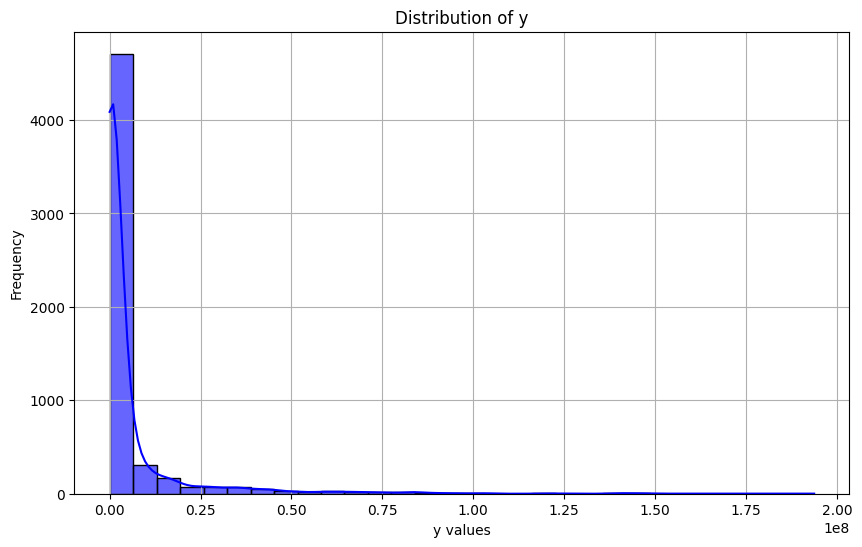

In [44]:
# Plotting
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.histplot(y, kde=True, bins=30, color='blue', alpha=0.6)  # Histogram with density line
plt.title('Distribution of y')  # Title of the plot
plt.xlabel('y values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.grid(True)  # Optional: Adds gridlines
plt.show()

In [143]:
from sklearn.linear_model import LassoCV

# Define features and target
X = final_df.drop(columns='future3year_total_y')  # Use all features except the target for inputs
y = final_df['future3year_total_y']  # Target variable

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Separate 'Year' and 'Area' columns
X_train_year_area = X_train[['Year', 'Area']] 
X_val_year_area = X_val[['Year', 'Area']]
X_test_year_area = X_test[['Year', 'Area']]

X_train_rest = X_train.drop(columns=['Year', 'Area'])
X_val_rest = X_val.drop(columns=['Year', 'Area'])
X_test_rest = X_test.drop(columns=['Year', 'Area'])

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
X_train_rest_transformed = pt.fit_transform(X_train_rest)
X_val_rest_transformed = pt.transform(X_val_rest)
X_test_rest_transformed = pt.transform(X_test_rest)

# Log transform of the target variable
y_train_log = np.log1p(y_train + 1)
y_val_log = np.log1p(y_val + 1)
y_test_log = np.log1p(y_test + 1)

# Normalize the numerical data using MaxAbsScaler
scaler_X = RobustScaler()
scaler_y = RobustScaler()
X_train_rest_scaled = scaler_X.fit_transform(X_train_rest_transformed)
X_val_rest_scaled = scaler_X.transform(X_val_rest_transformed)
X_test_rest_scaled = scaler_X.transform(X_test_rest_transformed)
y_train_scaled = scaler_y.fit_transform(y_train_log.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val_log.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_log.values.reshape(-1, 1))

# Scale 'Year' and 'Area' columns
scaler_year_area = RobustScaler()
X_train_year_area_scaled = scaler_year_area.fit_transform(X_train_year_area)
X_val_year_area_scaled = scaler_year_area.transform(X_val_year_area)
X_test_year_area_scaled = scaler_year_area.transform(X_test_year_area)

# Feature selection using Lasso
lasso = LassoCV(cv=5, random_state=42).fit(X_train_rest_scaled, y_train_scaled.ravel())
selected_features = np.where(lasso.coef_ != 0)[0]

X_train_selected = X_train_rest_scaled[:, selected_features]
X_val_selected = X_val_rest_scaled[:, selected_features]
X_test_selected = X_test_rest_scaled[:, selected_features]

# Concatenate 'Year' and 'Area' with the selected features
X_train_final = np.hstack((X_train_year_area_scaled, X_train_selected))
X_val_final = np.hstack((X_val_year_area_scaled, X_val_selected))
X_test_final = np.hstack((X_test_year_area_scaled, X_test_selected))

# Build the MLP model
model = Sequential([
    Dense(100, input_dim=X_train_final.shape[1]),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(50),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_final, y_train_scaled, validation_data=(X_val_final, y_val_scaled),
                    epochs=100, batch_size=8, callbacks=[early_stopping], verbose=1)

# Model evaluation
y_pred_scaled = model.predict(X_test_final)

# Calculate metrics
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred_scaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

print('================================')

# Inverse transform the predictions to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Reverse the log transformation
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test_original)

# Create a DataFrame with the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test_original.flatten(),  # Flatten because y_test_original may be a 2D array
    'Predicted': y_pred_original.flatten()  # Ensure y_pred is also flattened in case it is not
})

# Optionally, calculate the difference
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']

# Display the DataFrame to see the comparison
print(comparison_df.head())

print('===============================================')

# Create a DataFrame with the actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test_original.flatten(),  # Flatten because y_test_original may be a 2D array
    'Predicted': y_pred_original.flatten()  # Ensure y_pred is also flattened in case it is not
})

# Optionally, calculate the difference
comparison_df['Percentage to Actual (%)'] = round((comparison_df['Predicted'] / comparison_df['Actual']) * 100, 2)

# Display the DataFrame to see the comparison
print(comparison_df.head())


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.872e-01
  model = cd_fast.enet_coordinate_descent(


Epoch 1/100
392/392 [==============================] - 4s 5ms/step - loss: 0.8929 - mean_absolute_percentage_error: 799.2642 - val_loss: 0.2792 - val_mean_absolute_percentage_error: 506.7853
Epoch 2/100
392/392 [==============================] - 1s 4ms/step - loss: 0.4458 - mean_absolute_percentage_error: 697.8692 - val_loss: 0.1585 - val_mean_absolute_percentage_error: 199.6957
Epoch 3/100
392/392 [==============================] - 2s 4ms/step - loss: 0.3151 - mean_absolute_percentage_error: 384.3578 - val_loss: 0.1310 - val_mean_absolute_percentage_error: 175.2089
Epoch 4/100
392/392 [==============================] - 1s 4ms/step - loss: 0.2517 - mean_absolute_percentage_error: 475.3863 - val_loss: 0.1093 - val_mean_absolute_percentage_error: 193.9639
Epoch 5/100
392/392 [==============================] - 2s 5ms/step - loss: 0.2196 - mean_absolute_percentage_error: 362.5828 - val_loss: 0.0885 - val_mean_absolute_percentage_error: 184.8600
Epoch 6/100
392/392 [========================

In [144]:
# Configuration for KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare arrays to store results
mse_scores = []
mae_scores = []
rmse_scores = []
r2_scores = []
mape_scores = []

early_stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_index, test_index in kf.split(X):
    # Split data into train and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_year_area = X_train[['Year', 'Area']]
    X_test_year_area = X_test[['Year', 'Area']]

    X_train_rest = X_train.drop(columns=['Year', 'Area'])
    X_test_rest = X_test.drop(columns=['Year', 'Area'])

    # Data transformation and scaling as before
    pt = PowerTransformer(method='yeo-johnson')
    scaler_X = MaxAbsScaler()
    scaler_y = MaxAbsScaler()
    
    X_train_transformed = pt.fit_transform(X_train)
    X_test_transformed = pt.transform(X_test)
    X_train_scaled = scaler_X.fit_transform(X_train_transformed)
    X_test_scaled = scaler_X.transform(X_test_transformed)
    
    y_train_log = np.log1p(y_train + 1)
    y_test_log = np.log1p(y_test + 1)
    y_train_scaled = scaler_y.fit_transform(y_train_log.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test_log.values.reshape(-1, 1))
    
    # Scale 'Year' and 'Area' columns
    scaler_year_area = MaxAbsScaler()
    X_train_year_area_scaled = scaler_year_area.fit_transform(X_train_year_area)
    X_test_year_area_scaled = scaler_year_area.transform(X_test_year_area)

    # Feature selection using Lasso
    lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train_scaled.ravel())
    selected_features = np.where(lasso.coef_ != 0)[0]

    X_train_selected = X_train_scaled[:, selected_features]
    X_test_selected = X_test_scaled[:, selected_features]

    # Concatenate 'Year' and 'Area' with the selected features
    X_train_final = np.hstack((X_train_year_area, X_train_selected))
    X_test_final = np.hstack((X_test_year_area, X_test_selected))
    
    # Build and compile the model
    model = Sequential([
        Dense(100, input_dim=X_train_scaled.shape[1]),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(50),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

    # Fit the model
    model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=10, verbose=0,callbacks=[early_stopper], validation_split=0.2)

    # Predict and evaluate the model
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test_scaled)
    
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred_original)
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

    # Store scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mape_scores.append(mape)

# Calculate average scores across all folds
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R2: {np.mean(r2_scores)}")
print(f"Average MAPE: {np.mean(mape_scores)}%")


35/35 [==============================] - 0s 3ms/step
Average MSE: 0.9760234437896489
Average MAE: 0.5296731979505853
Average RMSE: 0.9758590082554394
Average R2: 0.894175133489766
Average MAPE: 10.5198288133054%


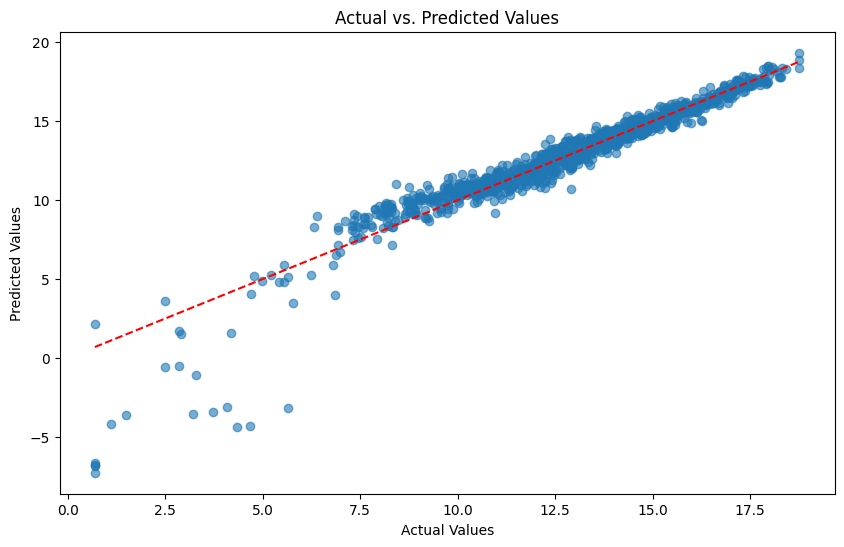

In [145]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [154]:
comparison_df.reset_index(inplace=True)

In [150]:
comparison_df.drop(columns='Percentage to Actual (%)', inplace=True)

In [156]:
comparison_df.to_csv('comparison_df.csv', index=False)